# Lab 4: TinyVGG Model Training

In this lab, we will build and train a convolutional neural network (CNN) for image classification.

## Learning Objectives

By the end of this lab, you will be able to:
- Understand CNN architecture components (Conv2d, ReLU, MaxPool2d)
- Build the TinyVGG model architecture
- Implement training and testing step functions
- Train a model and track metrics (loss, accuracy)
- Visualize training progress with loss curves

## 0. Setup

First, let's install the required packages and set up our computing device.

**Run the installation cell below first**, then run the imports cell.

In [4]:
# Install required packages (run this cell first)
!pip install torch torchvision tqdm matplotlib requests

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
     ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
     ---------------------------------------- 52.8/52.8 kB 2.7 MB/s eta 0:00:00
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
     ---------------------------------------- 0.0/116.4 kB ? eta -:--:--
     -------------------------------------- 116.4/116.4 kB 3.4 MB/s eta 0:00:00
  Using cached charset_normalizer-3.4.4-cp312-cp312-win_amd64.whl.metadata (38 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached markupsafe-3.0.3-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB 6.1 MB/s eta 0:


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


f:\poridhi-ai-labs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Data

We'll download and prepare the Pizza, Steak, Sushi dataset for training our CNN model.

In [6]:
import requests
import zipfile

# Setup paths
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# Download data if it doesn't exist
if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Creating {image_path} directory...')
    image_path.mkdir(parents=True, exist_ok=True)
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://raw.githubusercontent.com/poridhioss/Introduction-to-Deep-Learning-with-Pytorch-Resources/main/Transfer-learning/pizza_steak_sushi.zip')
        print('Downloading data...')
        f.write(request.content)
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping data...')
        zip_ref.extractall(image_path)
    print('Done!')

Creating data\pizza_steak_sushi directory...
Unzipping data...
Done!


Now that the data is downloaded, let's set up our training and test directories.

We'll apply a simple transform to:
- **Resize** images to 64x64 pixels (consistent input size)
- **Convert to Tensor** (normalize pixel values to [0, 1])

In [7]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Create transforms and datasets
simple_transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
train_data = datasets.ImageFolder(train_dir, transform=simple_transform)
test_data = datasets.ImageFolder(test_dir, transform=simple_transform)
class_names = train_data.classes

print(f'Train dir: {train_dir}')
print(f'Test dir: {test_dir}')
print(f'Classes: {class_names}')

Train dir: data\pizza_steak_sushi\train
Test dir: data\pizza_steak_sushi\test
Classes: ['pizza', 'steak', 'sushi']


In [8]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

DataLoaders are now ready to serve batches of data during training and evaluation.

## 2. Create TinyVGG Model

### Understanding CNN Architecture

TinyVGG is a simplified version of VGG (Visual Geometry Group) network. It uses:

| Component | Purpose |
|-----------|---------|
| **Conv2d** | Extract spatial features using learnable filters |
| **ReLU** | Add non-linearity (allows learning complex patterns) |
| **MaxPool2d** | Reduce spatial dimensions, keep strongest features |
| **Flatten** | Convert 2D feature maps to 1D vector |
| **Linear** | Final classification layer |

### Architecture Diagram

```
Input [3, 64, 64]
    ↓
Conv Block 1: Conv → ReLU → Conv → ReLU → MaxPool
    ↓ [hidden, 32, 32]
Conv Block 2: Conv → ReLU → Conv → ReLU → MaxPool  
    ↓ [hidden, 16, 16]
Flatten → Linear → Output [num_classes]
```

In [9]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1), nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(hidden_units*16*16, output_shape))
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [10]:
model_0 = TinyVGG(3, 10, len(class_names)).to(device)
print(model_0)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)


## 2.1. Test the Model with a Forward Pass

### Why Test Before Training?

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:

1. **Get a batch** from the DataLoader
2. **Extract single image** and add batch dimension with `unsqueeze()`
3. **Forward pass** in eval mode with `torch.inference_mode()`
4. **Convert outputs**: Logits → Probabilities (softmax) → Labels (argmax)

> **Note:** Predictions will be random/poor before training - this is expected!

In [11]:
img_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.0293,  0.0065, -0.0210]])

Output prediction probabilities:
tensor([[0.3284, 0.3404, 0.3312]])

Output prediction label:
tensor([1])

Actual label:
2


The model is outputting predictions as expected:
- **Logits**: Raw model outputs (can be any real number)
- **Probabilities**: Softmax converts logits to values between 0-1 that sum to 1
- **Predicted Label**: The class with highest probability

> **Note:** Predictions are likely wrong at this stage because the model hasn't been trained yet and is using random weights.

## 2.2. Visualize Model Architecture with torchinfo

### Understanding Model Internals

Printing out our model with print(model) gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the forward() method.

However, a helpful way to get information from our model is to use torchinfo.

### Using torchinfo.summary()

The [`torchinfo`](https://github.com/TylerYep/torchinfo) library provides a detailed model summary similar to Keras' `model.summary()`.

**What it shows:**
- Layer-by-layer output shapes as data flows through
- Number of trainable parameters
- Memory estimates
- Total multiply-add operations

This is invaluable for:
- **Debugging shape mismatches** before training
- **Understanding model complexity**
- **Optimizing architecture** (reducing parameters/memory)

In [12]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

# Pass the model and input size to get a detailed architecture summary
summary(model_0, input_size=[1, 3, 64, 64])


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

The `torchinfo.summary()` output provides valuable insights:

| Metric | Value | Meaning |
|--------|-------|---------|
| **Total params** | 10,693 | Number of learnable weights in the model |
| **Total mult-adds** | 6.75 MB | Computational cost per forward pass |
| **Estimated Total Size** | 0.91 MB | Memory footprint of the model |

You can also trace how tensor shapes change as data flows through each layer. Our model is intentionally small to enable fast experimentation.

## 3. Training Functions

We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

Training a neural network involves these steps for each batch:

1. **Forward Pass**: `pred = model(X)` - Get predictions
2. **Calculate Loss**: `loss = loss_fn(pred, y)` - Compare with true labels
3. **Zero Gradients**: `optimizer.zero_grad()` - Clear old gradients
4. **Backward Pass**: `loss.backward()` - Compute gradients
5. **Update Weights**: `optimizer.step()` - Apply gradient descent

### Training vs Evaluation Mode

| Mode | Behavior |
|------|----------|
| `model.train()` | Enables dropout, batch norm updates |
| `model.eval()` | Disables dropout, freezes batch norm |
| `torch.inference_mode()` | Disables gradient computation (faster) |

In [13]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    loss, acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        l = loss_fn(pred, y)
        loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        acc += (pred.argmax(1) == y).sum().item() / len(y)
    return loss/len(dataloader), acc/len(dataloader)

The `train_step()` function is complete. Now let's create the `test_step()` function.

**Key differences from training:**
- No optimizer (no weight updates)
- No gradient computation needed
- Uses `torch.inference_mode()` for faster execution

In [14]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    loss, acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            acc += (pred.argmax(1) == y).sum().item() / len(y)
    return loss/len(dataloader), acc/len(dataloader)

Now let's combine `train_step()` and `test_step()` into a unified `train()` function that:
- Runs training and evaluation for multiple epochs
- Tracks and returns all metrics in a dictionary
- Displays progress using tqdm

In [15]:
def train(model, train_dl, test_dl, opt, loss_fn, epochs, device):
    results = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in tqdm(range(epochs)):
        tl, ta = train_step(model, train_dl, loss_fn, opt, device)
        vl, va = test_step(model, test_dl, loss_fn, device)
        print(f'Epoch {epoch+1} | Train: {tl:.4f}/{ta:.4f} | Test: {vl:.4f}/{va:.4f}')
        results['train_loss'].append(tl)
        results['train_acc'].append(ta)
        results['test_loss'].append(vl)
        results['test_acc'].append(va)
    return results

## 4. Train Model

Now we have all the components ready:
- **Data**: Train and test DataLoaders
- **Model**: TinyVGG architecture
- **Functions**: Training and evaluation loops

Let's train the model with these hyperparameters:

| Component | Choice | Purpose |
|-----------|--------|---------|
| **Loss Function** | `CrossEntropyLoss` | Standard for multi-class classification |
| **Optimizer** | `Adam` | Adaptive learning rate, works well by default |
| **Learning Rate** | `0.001` | Step size for weight updates |
| **Epochs** | `5` | Number of complete passes through dataset |

> **Tip**: Setting `torch.manual_seed(42)` ensures reproducible results.

In [16]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(3, 10, len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

results = train(model_0, train_dataloader, test_dataloader, optimizer, loss_fn, 5, device)

 20%|██        | 1/5 [00:03<00:13,  3.33s/it]

Epoch 1 | Train: 1.1078/0.2578 | Test: 1.1362/0.2604


 40%|████      | 2/5 [00:04<00:06,  2.04s/it]

Epoch 2 | Train: 1.0846/0.4258 | Test: 1.1622/0.1979


 60%|██████    | 3/5 [00:05<00:03,  1.67s/it]

Epoch 3 | Train: 1.1153/0.2930 | Test: 1.1695/0.1979


 80%|████████  | 4/5 [00:07<00:01,  1.62s/it]

Epoch 4 | Train: 1.0988/0.4141 | Test: 1.1343/0.1979


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]

Epoch 5 | Train: 1.0990/0.2930 | Test: 1.1433/0.1979


### Training Results Analysis

The model shows poor performance (~25-30% accuracy on 3 classes is close to random guessing).

**Possible reasons:**
- Only 5 epochs of training
- Small model capacity (10 hidden units)
- No data augmentation
- Small dataset (225 training images)

We'll analyze the loss curves next to better understand the training dynamics.

## 5. Plot Loss Curves

Loss curves visualize how the model's performance changes during training. They are essential for diagnosing training issues.

### Interpreting Loss Curves

| Pattern | Meaning |
|---------|---------|
| Both decreasing | Model is learning properly |
| Train ↓, Test ↑ | **Overfitting** - memorizing training data |
| Both flat | Model not learning - try different hyperparameters |
| Both high | **Underfitting** - model too simple |

**Goal**: Both curves should decrease and converge to similar values.

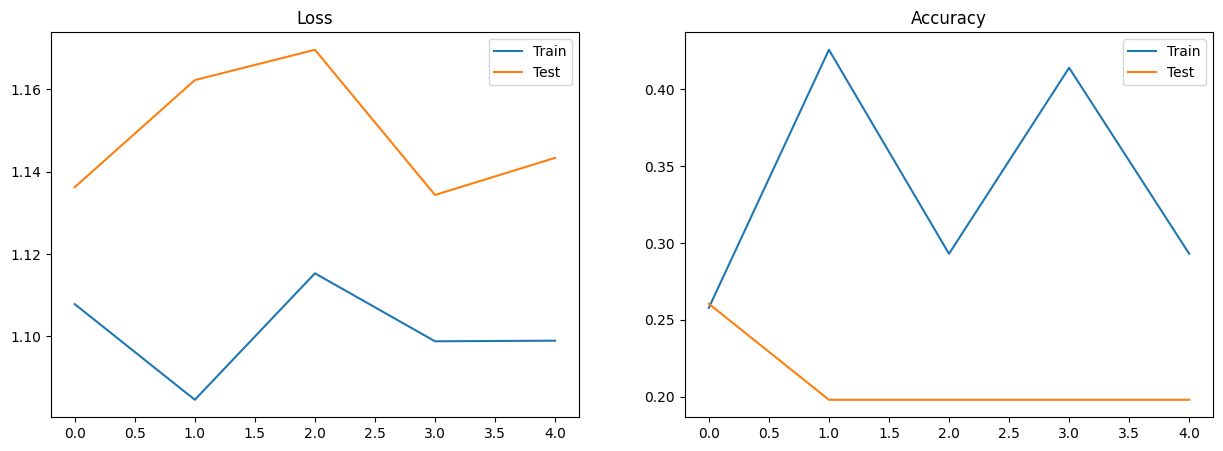

In [17]:
def plot_loss_curves(results):
    epochs = range(len(results['train_loss']))
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(epochs, results['train_loss'], label='Train')
    axes[0].plot(epochs, results['test_loss'], label='Test')
    axes[0].set_title('Loss'); axes[0].legend()
    axes[1].plot(epochs, results['train_acc'], label='Train')
    axes[1].plot(epochs, results['test_acc'], label='Test')
    axes[1].set_title('Accuracy'); axes[1].legend()
    plt.show()

plot_loss_curves(results)

## 6. Make Predictions on Custom Images

Now let's test our trained model on a completely new image it has never seen before.

### Steps for Custom Prediction:
1. **Load the image** - Download or read from file
2. **Preprocess** - Apply same transforms as training (resize, normalize)
3. **Add batch dimension** - Model expects [N, C, H, W], not [C, H, W]
4. **Set eval mode** - `model.eval()` + `torch.inference_mode()`
5. **Get prediction** - Forward pass → softmax → argmax

In [19]:
import torchvision

# Download custom image if it doesn't exist
custom_image_path = data_path / '04-pizza-dad.jpeg'
if not custom_image_path.is_file():
    print("Downloading custom pizza image...")
    import requests
    img_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
    img_data = requests.get(img_url).content
    with open(custom_image_path, 'wb') as f:
        f.write(img_data)
    print("Done!")

custom_image = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image shape: {custom_image.shape}')

Done!
Custom image shape: torch.Size([3, 4032, 3024])


In [20]:
def pred_and_plot_image(model, image_path, class_names, transform, device):
   
    img = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.0
    transformed_img = transform(img)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        pred_logits = model(transformed_img.unsqueeze(0).to(device))
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_probs.max().cpu():.3f}")
    plt.axis(False)
    plt.show()
    
    return class_names[pred_label.cpu()]

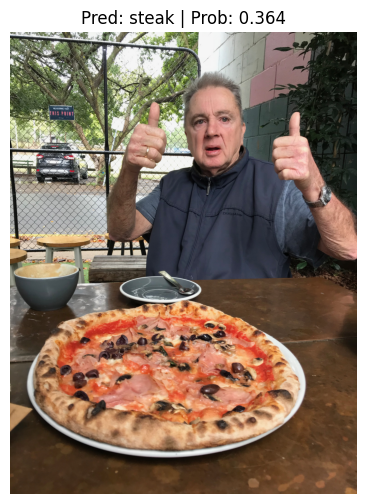

Prediction: steak


In [21]:
pred_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

prediction = pred_and_plot_image(
    model=model_0,
    image_path=custom_image_path,
    class_names=class_names,
    transform=pred_transform,
    device=device
)
print(f"Prediction: {prediction}")

Looks like our model got the prediction right just by guessing. 

We'll take of it later.

### Prediction Analysis

With only ~25% test accuracy, the model is essentially guessing randomly among 3 classes. Whether the prediction is correct or not depends largely on chance.

**To improve predictions, consider:**
- Training for more epochs (50-100+)
- Using data augmentation (`TrivialAugmentWide`)
- Increasing model capacity (more hidden units)
- Using transfer learning with pretrained models

## Key Takeaways

| Concept | Description |
|---------|-------------|
| **TinyVGG** | Simple CNN with 2 conv blocks + classifier |
| **Data Augmentation** | Artificially increase training data diversity |
| **TrivialAugmentWide** | Auto-select augmentation technique |
| **Training Loop** | Forward → Loss → Backward → Update |
| **Loss Curves** | Visual tool to diagnose training behavior |
| **Custom Prediction** | Load → Transform → Predict → Interpret |

## Congratulations!

You've completed the Custom Datasets with PyTorch lab series! You now know how to:

1. **Prepare Data** - Download and explore image datasets
2. **Transform Data** - Apply preprocessing and augmentation
3. **Load Data** - Use ImageFolder and custom Dataset classes
4. **Build Models** - Create CNN architectures like TinyVGG
5. **Train Models** - Implement training loops with metrics tracking